In [2]:
# Import packages
import pandas as pd, numpy as np
import tensorflow as tf
assert tf.__version__ >= '2.0'

from itertools import islice

# Keras
from keras.layers import Dense, Embedding, LSTM, Dropout, MaxPooling1D, Conv1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.preprocessing import sequence
from keras.datasets import imdb

from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [3]:
vocab_size = 10000
maxlen = 300
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocab_size)

In [4]:
x_train = pad_sequences(x_train, maxlen = maxlen, padding = 'pre')
x_test =  pad_sequences(x_test, maxlen = maxlen, padding = 'pre')

In [5]:
X = np.concatenate((x_train, x_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = random_state, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'Number of columns in training dataset: {x_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')


print('---'*20, f'\nNumber of rows in validation dataset: {x_valid.shape[0]}')
print(f'Number of columns in validation dataset: {x_valid.shape[1]}')
print(f'Number of unique words in validation dataset: {len(np.unique(np.hstack(x_valid)))}')


print('---'*20, f'\nNumber of rows in test dataset: {x_test.shape[0]}')
print(f'Number of columns in test dataset: {x_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')


print('---'*20, f'\nUnique Categories: {np.unique(y_train), np.unique(y_valid), np.unique(y_test)}')

------------------------------------------------------------ 
Number of rows in training dataset: 32000
Number of columns in training dataset: 300
Number of unique words in training dataset: 9999
------------------------------------------------------------ 
Number of rows in validation dataset: 8000
Number of columns in validation dataset: 300
Number of unique words in validation dataset: 9984
------------------------------------------------------------ 
Number of rows in test dataset: 10000
Number of columns in test dataset: 300
Number of unique words in test dataset: 9995
------------------------------------------------------------ 
Unique Categories: (array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64))


In [6]:
def decode_review(x, y):
  w2i = imdb.get_word_index()                                
  w2i = {k:(v + 3) for k, v in w2i.items()}
  w2i['<PAD>'] = 0
  w2i['<START>'] = 1
  w2i['<UNK>'] = 2
  i2w = {i: w for w, i in w2i.items()}

  ws = (' '.join(i2w[i] for i in x))
  print(f'Review: {ws}')
  print(f'Actual Sentiment: {y}')
  return w2i, i2w

w2i, i2w = decode_review(x_train[0], y_train[0])

# get first 50 key, value pairs from id to word dictionary
print('---'*30, '\n', list(islice(i2w.items(), 0, 50)))

Review: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> the only possible way to enjoy this flick is to bang your head against the wall allow some internal <UNK> of the brain let a bunch of your brain cells die and once you are officially mentally retarded perhaps then you might enjoy this film br br the only saving grace was the story between <UNK> and stephanie govinda was excellent in the role of the cab driver and so was the brit girl perhaps if they would have created the whole movie on their <UNK> in india and how they eventually fall in love would have made it a much more enjoyable film br br the onl

In [7]:
# Model
model = Sequential()
model.add(Embedding(vocab_size, 256, input_length = maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(Conv1D(128, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size = 2))
model.add(LSTM(75))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 0)  
mc = ModelCheckpoint('imdb_model.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 256)          2560000   
                                                                 
 dropout (Dropout)           (None, 300, 256)          0         
                                                                 
 conv1d (Conv1D)             (None, 300, 256)          327936    
                                                                 
 conv1d_1 (Conv1D)           (None, 300, 128)          163968    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 128)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 150, 64)           41024     
                                                        

In [8]:
# Fit the model
model.fit(x_train, y_train, validation_data = (x_valid, y_valid), epochs = 3, batch_size = 64, verbose = True, callbacks = [es, mc])

# Evaluate the model
scores = model.evaluate(x_test, y_test, batch_size = 64)
print('Test accuracy: %.2f%%' % (scores[1]*100))

Epoch 1/3
500/500 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8364
Epoch 1: val_loss improved from inf to 0.26550, saving model to imdb_model.h5
500/500 [==============================] - 256s 503ms/step - loss: 0.3458 - accuracy: 0.8364 - val_loss: 0.2655 - val_accuracy: 0.8909
Epoch 2/3
500/500 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9293
Epoch 2: val_loss improved from 0.26550 to 0.26301, saving model to imdb_model.h5
500/500 [==============================] - 247s 495ms/step - loss: 0.1840 - accuracy: 0.9293 - val_loss: 0.2630 - val_accuracy: 0.8919
Epoch 2: early stopping
157/157 [==============================] - 18s 104ms/step - loss: 0.2550 - accuracy: 0.8961
Test accuracy: 89.61%


In [9]:
y_pred = model.predict(x_test)
classes_y=np.argmax(y_pred,axis=1)
print(f'Classification Report:\n{classification_report(classes_y, y_test)}')

313/313 [==============================] - 18s 55ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.49      0.66     10000
           1       0.00      0.00      0.00         0

    accuracy                           0.49     10000
   macro avg       0.50      0.25      0.33     10000
weighted avg       1.00      0.49      0.66     10000



In [10]:
sample_x_test = x_test[np.random.randint(10000)]
for layer in model.layers:

    model_layer = Model(inputs = model.input, outputs = model.get_layer(layer.name).output)
    output = model_layer.predict(sample_x_test.reshape(1,-1))
    print('\n','--'*20, layer.name, 'layer', '--'*20, '\n')
    print(output)

1/1 [==============================] - 0s 165ms/step

 ---------------------------------------- embedding layer ---------------------------------------- 

[[[-0.02355237  0.01869611  0.01020116 ...  0.033794   -0.00484663
   -0.02196977]
  [-0.02355237  0.01869611  0.01020116 ...  0.033794   -0.00484663
   -0.02196977]
  [-0.02355237  0.01869611  0.01020116 ...  0.033794   -0.00484663
   -0.02196977]
  ...
  [-0.01825208 -0.0048916  -0.01310902 ...  0.02955078 -0.00597665
    0.0174699 ]
  [ 0.06884262 -0.00655813 -0.03695503 ...  0.07633599 -0.00137153
   -0.00164432]
  [-0.00765142  0.01811628 -0.00335066 ... -0.01310326  0.02870468
    0.02515893]]]
1/1 [==============================] - 0s 161ms/step

 ---------------------------------------- dropout layer ---------------------------------------- 

[[[-0.02355237  0.01869611  0.01020116 ...  0.033794   -0.00484663
   -0.02196977]
  [-0.02355237  0.01869611  0.01020116 ...  0.033794   -0.00484663
   -0.02196977]
  [-0.02355237  0.01

In [11]:
decode_review(x_test[10], y_test[10])
print(f'Predicted sentiment: {y_pred[10][0]}')

Review: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Conclusion

Sentiment classification task on the IMDB dataset, on test dataset,

Accuracy: almost 90%

F1-score: above 90%

<font size=5 >Part-B</font>

<font size=2>1. Read and explore the data</font>

In [1]:
import pandas as pd
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [3]:
data.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [4]:
df_sarcastic = data.is_sarcastic.value_counts().to_frame()
df_sarcastic

,is_sarcastic
0,14985
1,13634


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

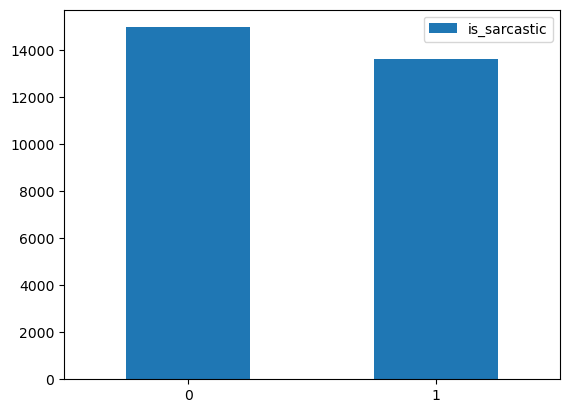

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
df_sarcastic.plot(kind = 'bar')
plt.xticks(rotation = 0)

In [6]:
sarcastic_headlines = data.loc[data['is_sarcastic'] == 1]
#undersample non sarcastic headline
non_sarcastic_headlines = data.loc[data['is_sarcastic'] == 0].sample(n = 11724, random_state = 25)

In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [8]:
text = ' '.join(review for review in sarcastic_headlines.headline)
print ('There are {} words in the combination of all review.'.format(len(text)))


There are 904356 words in the combination of all review.


Word cloud of Sarcastic Headlines

(-0.5, 399.5, 199.5, -0.5)

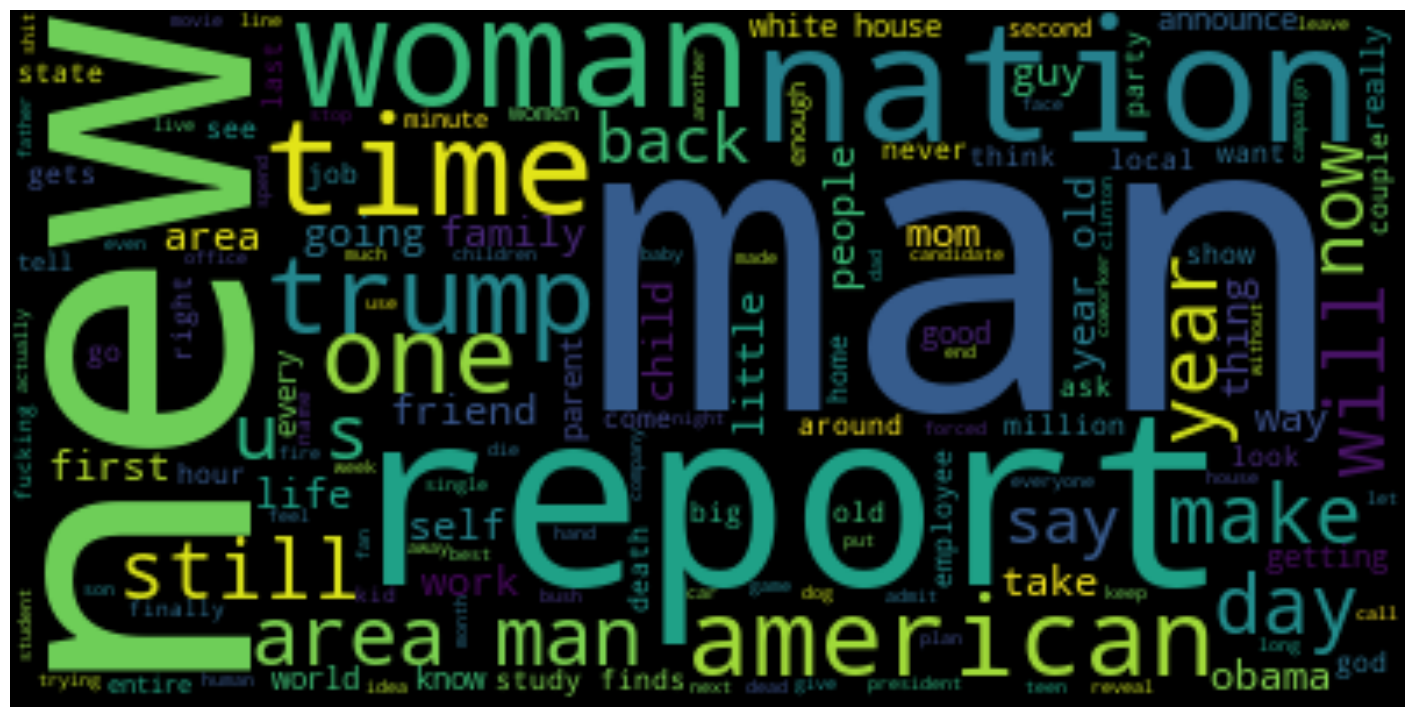

In [9]:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stopwords, background_color = "black").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = [18, 18])
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

Word cloud of Non Sarcastic Headline

In [10]:
text_ns = ' '.join(review for review in non_sarcastic_headlines.headline)
print ('There are {} words in the combination of all review.'.format(len(text_ns)))

There are 709999 words in the combination of all review.


(-0.5, 399.5, 199.5, -0.5)

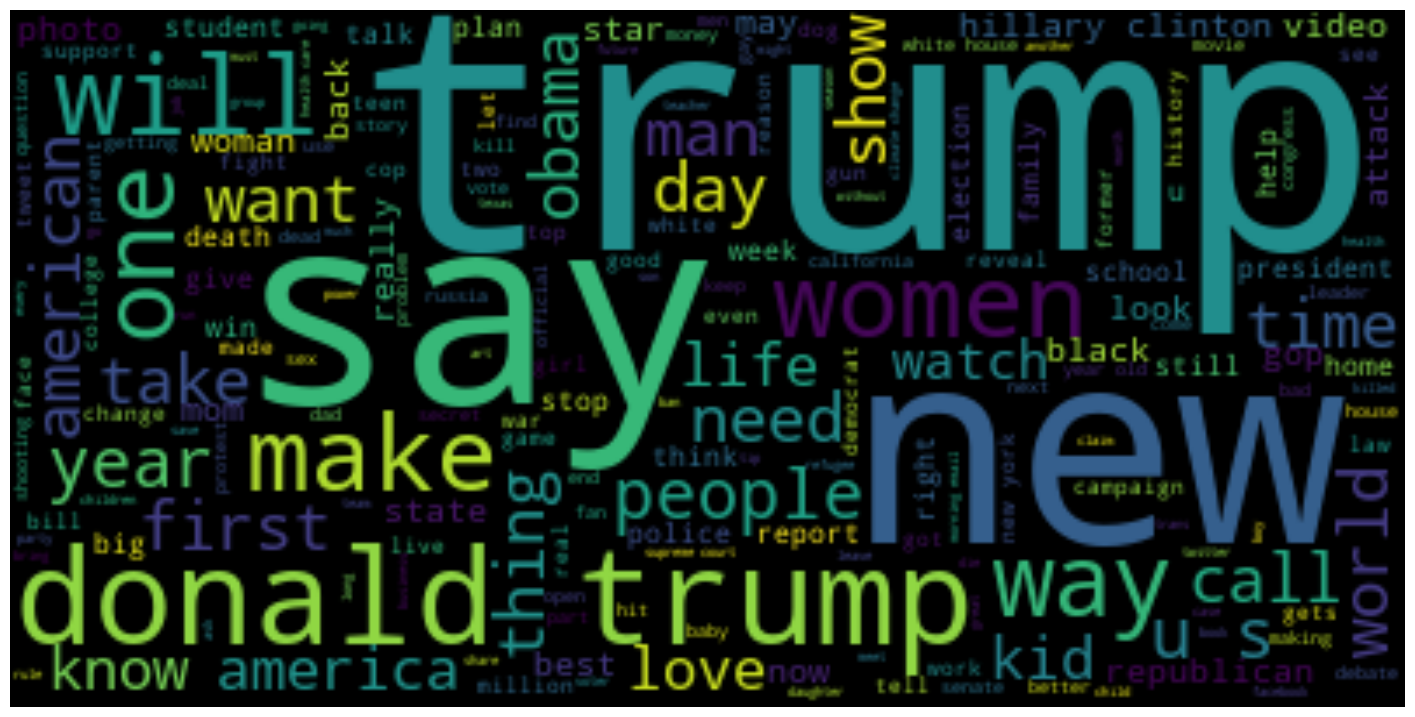

In [11]:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords = stopwords, background_color = "black").generate(text_ns)

# Display the generated image:
plt.figure(figsize = [18, 18])
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

2. Retain relevant columns

In [12]:
data = pd.concat([sarcastic_headlines, non_sarcastic_headlines])

In [13]:
data = data.drop(columns = 'article_link', axis = 1)
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...
7,1,richard branson's global-warming donation near...
8,1,shadow government getting too large to meet in...


3. Get length of each sentence

In [14]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [15]:
def clean_text(text, remove_stopwords=True):
  # Convert words to lower case
  text = text.lower()
  if True:
    text = text.split()
    new_text = []
    for word in text:
      if word in contractions:
        new_text.append(contractions[word])
      else:
        new_text.append(word)
      text = " ".join(new_text)
      text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
      text = re.sub(r'\<a href', ' ', text)
      text = re.sub(r'&amp;', '', text)
      text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
      text = re.sub(r'<br />', ' ', text)
      text = re.sub(r'\'', ' ', text)
      if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
  return text

In [16]:
import nltk
nltk.download('stopwords')

# Clean the headlines
import re
from nltk.corpus import stopwords 
from pickle import dump, load

clean_balanced_headlines = []
for headline in data['headline']:
  clean_balanced_headlines.append(clean_text(headline, remove_stopwords = False))
print('Data is cleaned!')

[nltk_data] Downloading package stopwords to C:\Users\Sandeep
[nltk_data]     Basetty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data is cleaned!


In [17]:
data['cleaned_headline'] = clean_balanced_headlines
data.head()

,is_sarcastic,headline,cleaned_headline
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close to using word strea...
7,1,richard branson's global-warming donation near...,richard branson s global warming donation near...
8,1,shadow government getting too large to meet in...,shadow government getting too large to meet in...


In [18]:
data = data.drop('headline', axis = 1)
data.head()

,is_sarcastic,cleaned_headline
0,1,thirtysomething scientists unveil doomsday clo...
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word strea...
7,1,richard branson s global warming donation near...
8,1,shadow government getting too large to meet in...


In [19]:
print (data['cleaned_headline'][8])

shadow government getting too large to meet in marriott conference room b


In [20]:
len(data['cleaned_headline'][8].split())

12

In [21]:
max_length = max([len(headline.split()) for headline in data['cleaned_headline']])
print('Maximum Length: ', max_length)

Maximum Length:  152


In [22]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

4. Define parameters

In [23]:
max_features = 10000
maxlen = max_length #39 in this case
embedding_size = 200

Apply Keras Tokenizer of headline column

In [24]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(data['cleaned_headline'])

6. Create features and labels

In [25]:
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 25358
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  318 2887 5898 1966    2  642 1215]
Number of Labels:  25358
1


7. Get vocabulary size

In [26]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)

Vocabulary Size:  25239


8. Create a weight matrix using GloVe embeddings

In [27]:
from zipfile import ZipFile
with ZipFile("glove.6B.zip",'r') as zip_ref:
 zip_ref.extractall()

In [28]:
#EMBEDDING_FILE ="glove.6B.200d.txt"

embeddings = {}
EMBEDDING_FILE = open('glove.6B.200d.txt', encoding='utf-8')
for o in EMBEDDING_FILE:
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

Create a weight matrix for words in training docs

In [29]:
embedding_matrix = np.zeros((vocab_size, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

9. Define and compile a Bidirectional LSTM model

In [37]:
### create the model
model = Sequential()

### Embedding layer for hint 
model.add(Embedding(vocab_size, embedding_size, weights = [embedding_matrix]))

### Bidirectional LSTM layer for hint 
model.add(Bidirectional(LSTM(512, return_sequences = True)))

### dense
model.add(Dense(256, activation = 'relu'))


##dropout
model.add(Dropout(0.5, input_shape = (256,)))


##sigmoid
model.add(Dense(1, activation = 'sigmoid'))
model.add(Flatten())
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 200)         5047800   
                                                                 
 bidirectional_7 (Bidirectio  (None, None, 1024)       2920448   
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, None, 256)         262400    
                                                                 
 dropout_4 (Dropout)         (None, None, 256)         0         
                                                                 
 dense_12 (Dense)            (None, None, 1)           257       
                                                                 
 flatten_7 (Flatten)         (None, None)              0         
                                                      

10. Fit the model and check the validation accuracy

In [38]:
batch_size = 50
epochs = 5

history = model.fit(X, y, batch_size = batch_size, epochs = epochs, verbose = 1, validation_split = 0.2)

Epoch 1/5
406/406 [==============================] - 951s 2s/step - loss: 0.6164 - accuracy: 8.8731e-04 - val_loss: 1.0909 - val_accuracy: 0.0000e+00
Epoch 2/5
406/406 [==============================] - 924s 2s/step - loss: 0.5641 - accuracy: 0.0010 - val_loss: 1.2776 - val_accuracy: 0.0000e+00
Epoch 3/5
406/406 [==============================] - 915s 2s/step - loss: 0.5677 - accuracy: 0.0105 - val_loss: 1.1328 - val_accuracy: 0.0000e+00
Epoch 4/5
406/406 [==============================] - 881s 2s/step - loss: 0.3222 - accuracy: 0.0233 - val_loss: 0.8317 - val_accuracy: 0.4109
Epoch 5/5
406/406 [==============================] - 859s 2s/step - loss: 0.1674 - accuracy: 0.0209 - val_loss: 0.6532 - val_accuracy: 0.3713
